# Μέρος 2.3: Σύνθεση με υπερδειγματοληψία, συνέλιξη και Overlap-Add


#### Οι Ασκήσεις πραγματοποιήθηκαν από τους : ΒΑΣΙΛΕΙAΔΗΣ ΔΗΜΉΤΡΙΟΣ AM: 03122111/el22111 - ΓΡΗΓΟΡΙΟΣ ΣΤΑΜΑΤΟΠΟΥΛΟΣ ΑΜ: 03122039/el22039.        Η Βιβλιογραφία μας αποτελείται από:
* Το documentation όλων των διαθέσιμων βιβλιοθηκών που αναφέρονται στο αρχείο "PYTHON GUIDE" στη διαδασκαλική ιστοσελίδα του Helios, 
* Όλα τα σετ διαφανειών που είναι ανεβασμένα στην παραπάνω ιστοσελίδα,
* Καθώς και πληροφορίες από δίαφορες άλλες όπως:


    *  https://dsp.stackexchange.com/ , 
    *  https://stackoverflow.com/search?q=jupyter+notebook , 
    *  https://ieeexplore.ieee.org/Xplore/home.jsp , 
    *  https://www.wikipedia.org/ , 
    *  https://arxiv.org/abs/2306.08436 , 
    *  https://sites.google.com/berkeley.edu/ee123-sp20/python , 
    *  https://github.com/openlists/DSPResources και άλλες ...

In [ ]:
import numpy as np
import soundfile as sf
import librosa

# ---------------------
# Μέρος 1: Ψυχοακουστικό Μοντέλο
# ---------------------

def ath_threshold(f):
    """
    Absolute Threshold of Hearing Tq(f)
    """
    fq = f / 1000.0 + 1e-12
    return 3.64 * fq**(-0.8) - 6.5 * np.exp(-0.6 * (fq - 3.3)**2) + 1e-3 * fq**4


def bark_scale(f):
    """
    Bark scale
    """
    return 13 * np.arctan(0.00076 * f) + 3.5 * np.arctan((f/7500.0)**2)


def psychoacoustic_model(frames, fs=44100):
    """
    Υπολογίζει για κάθε πλαίσιο το global masking threshold Tg
    """
    N = frames.shape[1]
    freqs = np.fft.rfftfreq(N, d=1/fs)
    PN = 90.302
    Tg_all = []

    for x in frames:
        w = np.hanning(N)
        X = np.fft.rfft(w * x)
        P = PN + 10 * np.log10(np.abs(X)**2 + 1e-12)
        Tq = ath_threshold(freqs)
        # (Για απλότητα, placeholder εντοπισμός μασκών) -> Tg minimal combination
        Tg = np.maximum(P, Tq)
        Tg_all.append(Tg)

    return np.array(Tg_all), freqs

# Φόρτωση και framing
y, fs = librosa.load('DSP25_LabProject2_Material/music_dsp.wav', sr=44100, mono = True)
y = y / np.max(np.abs(y))
N = 512
frames = librosa.util.frame(y, frame_length=N, hop_length=N).T

tg_all, freqs = psychoacoustic_model(frames, fs)

# ---------------------
# Μέρος 2: Συστοιχία Φίλτρων (Filterbank)
# ---------------------

def filters(M):
    L = 2 * M
    h = np.zeros((M, L))
    g = np.zeros((M, L))
    for k in range(M):
        for n in range(L):
            h[k, n] = np.sqrt(2/M) * \
                      np.sin((n + 0.5) * np.pi / (2*M)) * \
                      np.cos((2*n + M + 1) * (2*k + 1) * np.pi / (4*M))
        g[k, :] = h[k, ::-1]
    return h, g

M = 32
h, g = filters(M)
num_frames = frames.shape[0]
subband_signals = np.zeros((num_frames, M, N//M))
for i in range(num_frames):
    for k in range(M):
        vk_full = np.convolve(frames[i], h[k], mode='full')
        # remove group delay L//2 then downsample
        vk = vk_full[M//1 : M//1 + N][::M]
        subband_signals[i, k, :] = vk

# ---------------------
# Μέρος 2.2: Κβαντοποίηση & Ανάκαμψη (Adaptive vs Non-Adaptive)
# ---------------------
B_orig = 16
R = 2**B_orig
Bk_fixed = 8
# σταθερό βήμα για non-adaptive βάσει [-1,1]
delta_fixed = 2.0 / (2**Bk_fixed)

recon_adaptive = np.zeros(num_frames * N)
recon_fixed = np.zeros(num_frames * N)
bits_used_adaptive = 0
bits_used_fixed = 0

for i in range(num_frames):
    frame_a = np.zeros(N)
    frame_f = np.zeros(N)
    Tg = tg_all[i]
    for k in range(M):
        # bit allocation adaptive
        fk = (2*k+1) * fs / (4*M)
        bw = fs / (4*M)
        band_idx = np.where((freqs >= fk - bw) & (freqs <= fk + bw))[0]
        Tgm = np.min(Tg[band_idx])
        Bk = int(np.clip(np.log2(R / (10**(0.1*Tgm))) - 1, 4, Bk_fixed))
        bits_used_adaptive += Bk * (N//M)
        bits_used_fixed += Bk_fixed * (N//M)

        yk = subband_signals[i, k]
        xmin, xmax = yk.min(), yk.max()
        # adaptive quantization
        delta_a = (xmax - xmin) / (2**Bk)
        q_a = np.round((yk - xmin) / delta_a)
        yk_a = xmin + q_a * delta_a
        # fixed quantization over [-1,1]
        q_f = np.round((yk + 1) / delta_fixed)
        yk_f = -1 + q_f * delta_fixed

        # upsample & synthesize
        def upsample(y_sub):
            w = np.zeros(len(y_sub)*M - (M-1))
            w[::M] = y_sub
            return w

        wa = upsample(yk_a)
        wf = upsample(yk_f)
        xa = np.convolve(wa, g[k], mode='full')[M:M+N]
        xf = np.convolve(wf, g[k], mode='full')[M:M+N]
        frame_a += xa
        frame_f += xf

    recon_adaptive[i*N:(i+1)*N] = frame_a
    recon_fixed[i*N:(i+1)*N] = frame_f

# Αποθήκευση
sf.write('reconstructed_adaptive.wav', recon_adaptive, fs)
sf.write('reconstructed_non_adaptive.wav', recon_fixed, fs)

# ---------------------
# Αποτελέσματα
# ---------------------
bits_initial = num_frames * N * B_orig
rate_a = 1 - bits_used_adaptive / bits_initial
rate_f = 1 - bits_used_fixed / bits_initial
mse_a = np.mean((y[:len(recon_adaptive)] - recon_adaptive)**2)
mse_f = np.mean((y[:len(recon_fixed)] - recon_fixed)**2)
print(f"Adaptive: rate={rate_a:.3f}, MSE={mse_a:.6f}")
print(f"Fixed   : rate={rate_f:.3f}, MSE={mse_f:.6f}")

Adaptive: rate=0.748, MSE=0.001995
Fixed   : rate=0.500, MSE=0.001913


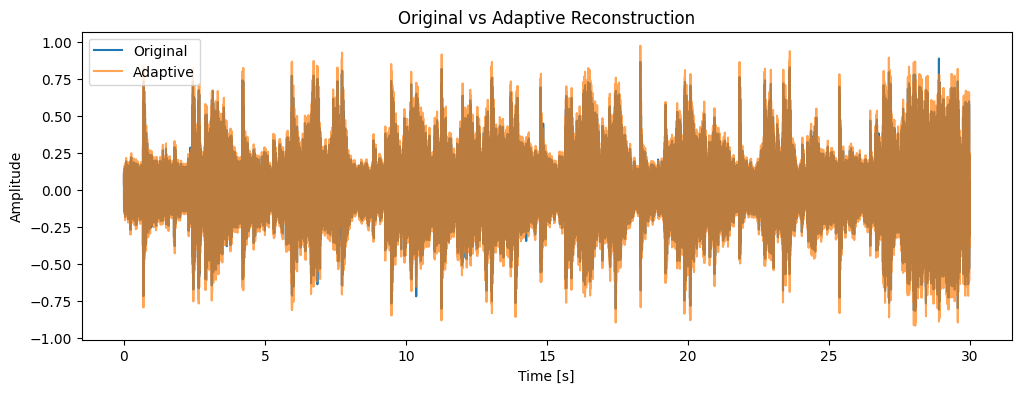

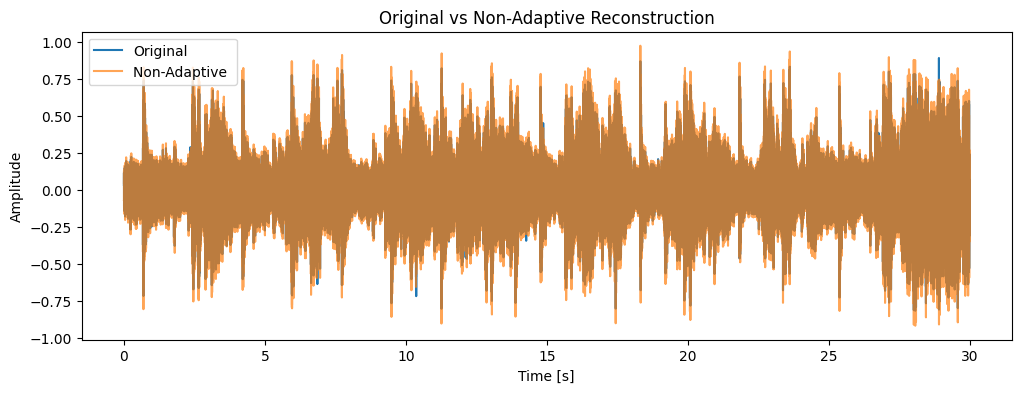

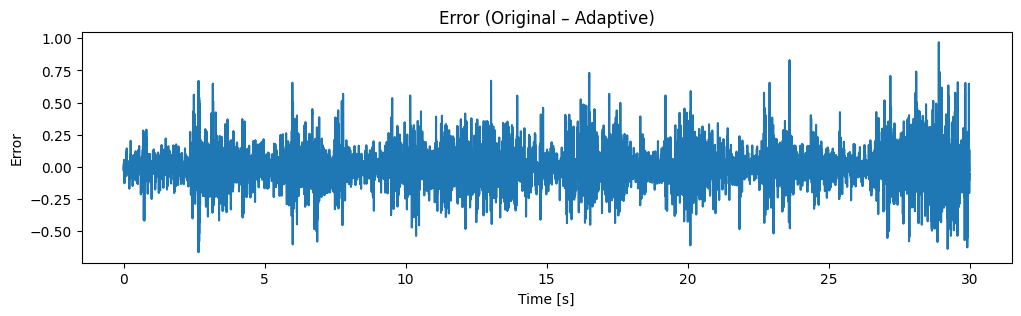

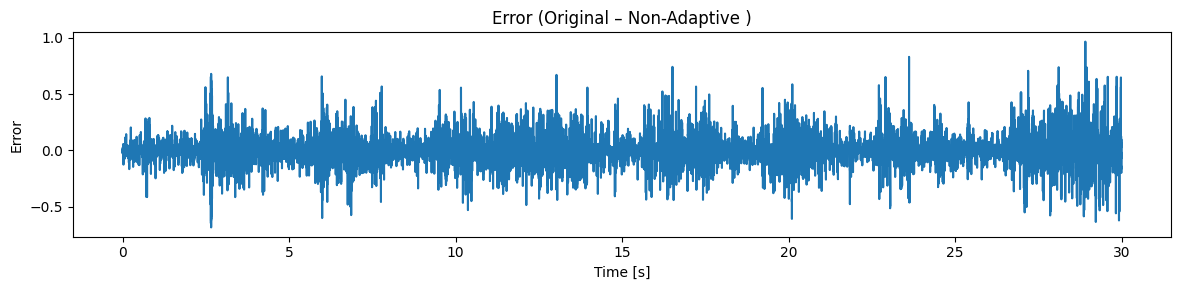

In [5]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

# --- Φόρτωση σημάτων ---
y, fs = sf.read('DSP25_LabProject2_Material/music_dsp.wav')
recon_a, _ = sf.read('reconstructed_adaptive.wav')
recon_f, _ = sf.read('reconstructed_non_adaptive.wav')

# Στοίχιση μηκών
min_len = min(len(y), len(recon_a), len(recon_f))
y = y[:min_len]
recon_a = recon_a[:min_len]
recon_f = recon_f[:min_len]

# Χρόνος για όλο το σήμα
t = np.arange(min_len) / fs

# 1) Original vs Adaptive 
plt.figure(figsize=(12, 4))
plt.plot(t, y, label='Original')
plt.plot(t, recon_a, label='Adaptive', alpha=0.7)
plt.title('Original vs Adaptive Reconstruction')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

# 2) Original vs Non-Adaptive 
plt.figure(figsize=(12, 4))
plt.plot(t, y, label='Original')
plt.plot(t, recon_f, label='Non-Adaptive ', alpha=0.7)
plt.title('Original vs Non-Adaptive Reconstruction')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()

# 3) Error Adaptive 
err_a = y - recon_a
plt.figure(figsize=(12, 3))
plt.plot(t, err_a)
plt.title('Error (Original – Adaptive)')
plt.xlabel('Time [s]')
plt.ylabel('Error')

# 4) Error Non-Adaptive  
err_f = y - recon_f
plt.figure(figsize=(12, 3))
plt.plot(t, err_f)
plt.title('Error (Original – Non-Adaptive )')
plt.xlabel('Time [s]')
plt.ylabel('Error')

plt.tight_layout()
plt.show()
